# Loading libraries and object

In [9]:
library(Matrix, lib.loc = "../R/4.0/library")
library(Seurat)
library(dplyr)
library(patchwork)
library(ggplot2)
library(pheatmap, warn.conflicts = FALSE)
library(tidyr)
library(ggpubr)
library(data.table)
library(ComplexHeatmap)
library(org.Hs.eg.db)
library(org.Mm.eg.db)
library(data.table)
library(ggnewscale, warn.conflicts = FALSE)
library(GSEABase)
library(fgsea)
library(ReactomePA,  warn.conflicts = FALSE)
library(clusterProfiler, warn.conflicts = FALSE)
library(SeuratWrappers)
library(paletteer, lib.loc="../R/4.0/library")
library(prismatic, lib.loc="../R/4.0/library")
library(stringr)
source("process_data.R")

new.cols <- paletteer::paletteer_d("ggthemes::Tableau_20")
new.cols.crop <- c(new.cols[6], new.cols[9], new.cols[7], new.cols[15])

In [5]:
matrix <- readMM("fibroblast_matrix.mtx")
barcodes <- read.table("fibroblast_barcodes.tsv", header = FALSE, stringsAsFactors = FALSE)
genes <- read.table("fibroblast_genes.tsv", header = FALSE, stringsAsFactors = FALSE)
metadata <- read.csv("fibroblast_metadata.csv", header = TRUE, row.names = 1)
rownames(matrix) <- genes$V1
colnames(matrix) <- barcodes$V1

object <- CreateSeuratObject(counts = matrix)
object <- AddMetaData(object, metadata = metadata)

Warning message:
“Data is of class dgTMatrix. Coercing to dgCMatrix.”


# FastMNN Integration

In [10]:
future::plan('multisession', workers = 6)
options(future.globals.maxSize = 3 * 1024^3)
DefaultAssay(object) <- "RNA"

object <- NormalizeData(object)
object <- FindVariableFeatures(object)
object <- RunFastMNN(object.list = SplitObject(object, split.by = "patient_code"))
object <- ScaleData(object) 
object <- FindNeighbors(object, reduction = "mnn", dims = 1:30)
object <- RunUMAP(object, reduction = "mnn", dims = 1:30)
object <- RunTSNE(object, reduction = "mnn", dims = 1:30)
object <- FindClusters(object, resolution = 1)

future::plan('sequential')

Computing 2000 integration features

Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Centering and scaling data matrix



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6409
Number of edges: 259705

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8210
Number of communities: 14
Elapsed time: 0 seconds


# Fibroblast: Assign labels to clusters
Note: cluster assignments are already in metadata

In [58]:
## source: https://panglaodb.se/markers.html
scEpithelial_cells_Signatures <- list(c('CD24','CDH1','KRT7','MUC1','KRT14','KRT3','ANPEP','SCGB1A1','KRT13','TP63','EPCAM','CLDN1','OCLN'))

scMesothelial_cells_Signatures <- list(c('MSLN','LRRN4','FRAS1','RSPO1'))

scBasal_cells_Signatures <- list(c('KRT5','KRT14','TP63','KRT6B','LAMB3','KRT15','LAMC2','BMP7','MYLK'))

scFibroblast_Signatures <- list(c('FLI1','CELA1','LOX','PDGFRB','P4HA1','CCR2','PRKCD','CTHRC1','COL15A1','GJB2','VTN','ITIH5','LUM','DPT','POSTN','MMP14','COL6A2','FABP4','ASPN','ANGPTL2','EFEMP1','SCARA5','IGFBP3','DPEP1','ADAMTS5','COL5A1','CD248','PI16','TNXB','MMP2',
                                'COL14A1','IGFBP6','COL5A2','FBN1','FKBP10','WIF1','SNHG18','CDH11','PTCH1','FBLN2','IGF1','PRRX1','COL6A3','CTSK','C1S','GREM1','SPON2','TCF21','PCSK6','COL8A1','ENTPD2','MMP23','CXCL8','CYP1B1','CCL11','CD55','PTX3','MMP3','FRZB','COL12A1',
                                'MEOX1','PRG4','PKD2','CCL19','NNMT','FOXF1','HAS1','CTGF','ERCC1','WISP1','TWIST2','RIPK3','DDR2','ELN','FN1','HHIP','FMO2','COL1A2','COL3A1','VIM','FSTL1','GSN','SPARC','S100A4','NT5E','COL1A1','MGP','NOX4','THY1','CD40','SERPINH1','CD44',
                                'PDGFRA','EN1','DCN','CEBPB','EGR1','FOSB','FOSL2','HIF1A','KLF2','KLF4','KLF6','KLF9','NFAT5','NFATC1','NFKB1','NR4A1','NR4A2','PBX1','RUNX1','STAT3','TCF4','ZEB2','LAMC1','MEDAG','MS4A4D','LAMB1','DKK3','TBX20','MDK','GSTM5','NGF','VEGFA',
                                'FGF2','P4HTM','CKAP4','INMT','CXCL14'))
scHepatic_stellate_Signatures <- list(c('MYL9','CALD1','MMP11','HOPX','BGN','IGFBP7','TPM2','CTHRC1','ACTA2','TAGLN','INHBA','COL10A1','TPM1','POSTN','GRP','CST1'))
myCAF_Signatures <- list(c('CTGF','ACTA2','COL1A1','TAGLN','COL1A2','COL3A1','SPARC','RBP1','DCN','MYL9','TPM2','MEG3','BGN','IGFBP7','IGFBP3','CYR61','OLFML3','IGFBP6','CCL2','COLEC11','HGF')) ## ref: https://aacrjournals.org/cancerdiscovery/article/9/8/1102/42174/Cross-Species-Single-Cell-Analysis-of-Pancreatic
iCAF_Signatures <- list(c('C3','DUSP1','FBLN1','LMNA','CLU','CCDC80','MYC','EFEMP1','HAS1','NR4A1','CFD','ANXA1','CXCL12','FGF7','KLF4','EMP1','GPRC5A','SRPX','MT2A','MEDAG','IGF1','MGST1','MCL1','CEBPD','S100A10','UAP1','TNXB','CEBPB','PNRC1','SOCS3','PTGDS','FOSB','NFKBIA','CXCL2',
                        'THBS1','CCL2','OGN','GSN','DPT','PLA2G2A','NAMPT','ITM2A','RGCC','JUND','NNMT','ZFP36','PIM1','CPE','GFPT2','SOD2','KDM6B','FSTL1','FBLN2','NR4A3','MFAP5','ABL2','SGK1','CILP','UGDH','FBLN5','ADAMTS1','ADH1B','WISP2','GPX3','S100A4','IL6','HAS2','PLAC9',
                        'IGFBP6','FBN1','BDKRB1','TPPP3','RASD1','MT1A','CXCL14','PI16','APOE','IL8','ARC','PTX3','TNFAIP6','MT1E','MT1X','CXCL1')) ## ref: https://aacrjournals.org/cancerdiscovery/article/9/8/1102/42174/Cross-Species-Single-Cell-Analysis-of-Pancreatic
apCAF_Signatures <- list(c("GJB3", "GJB5", "LSR", "EZR", "KRT19", "KRT18", "KRT8", "SDC4", "PTPRF", "CD82", "NFE2L3", 
                           "TPI1", "ID1", "FAM110C","CD74", "SLPI", "IL6", "CFD", "C1QA", "C1QB", "SFTC", "CLU", "LYZ", "HLA-DRA", "HLA-DRB1")) ## https://www.sciencedirect.com/science/article/pii/S1535610822001738 

In [66]:
object <- AddModuleScore(
  object = object,
  features = apCAF_Signatures, # replace signature here
  ctrl = 20,assay = "RNA",
  name = 'apCAF_Signatures', # replace name here
)


Warning message:
“The following features are not present in the object: SFTC, not searching for symbol synonyms”


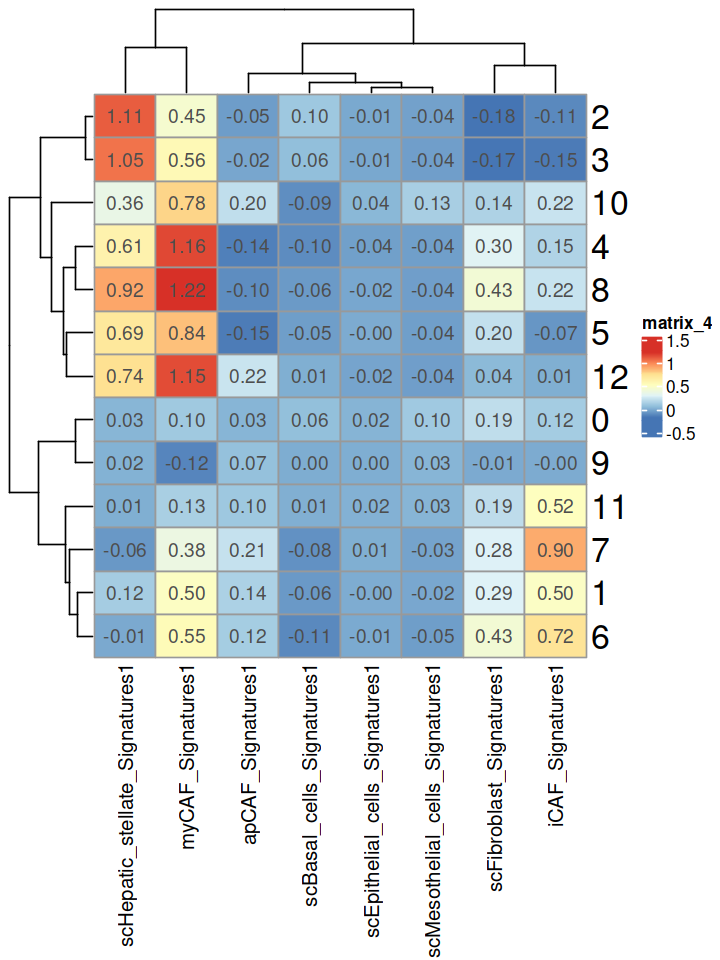

In [68]:
cols <- colnames(object@meta.data)
Signature <- cols[grepl("Signature",cols)]
        
Signature_mat <- object@meta.data %>% dplyr::select(all_of(Signature),seurat_clusters)  %>% 
group_by(seurat_clusters) %>% summarize_at(Signature, mean)
rownames(Signature_mat) <- NULL
Signature_mat <- tibble::column_to_rownames(Signature_mat, 'seurat_clusters') %>% as.matrix

options(repr.plot.height=8,repr.plot.width=6)
pheatmap(Signature_mat,cluster_cols=T,fontsize=14,display_numbers=T, fontsize_row = 20, fontsize_col = 12)

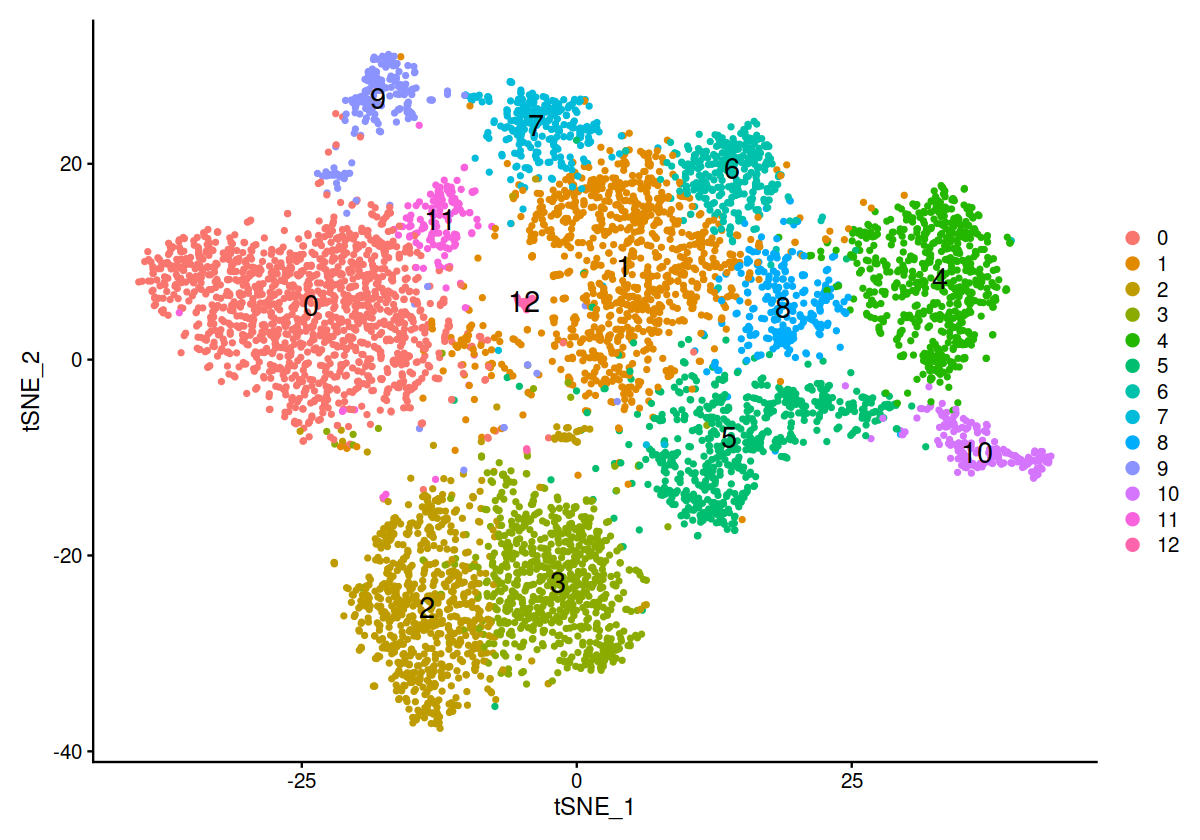

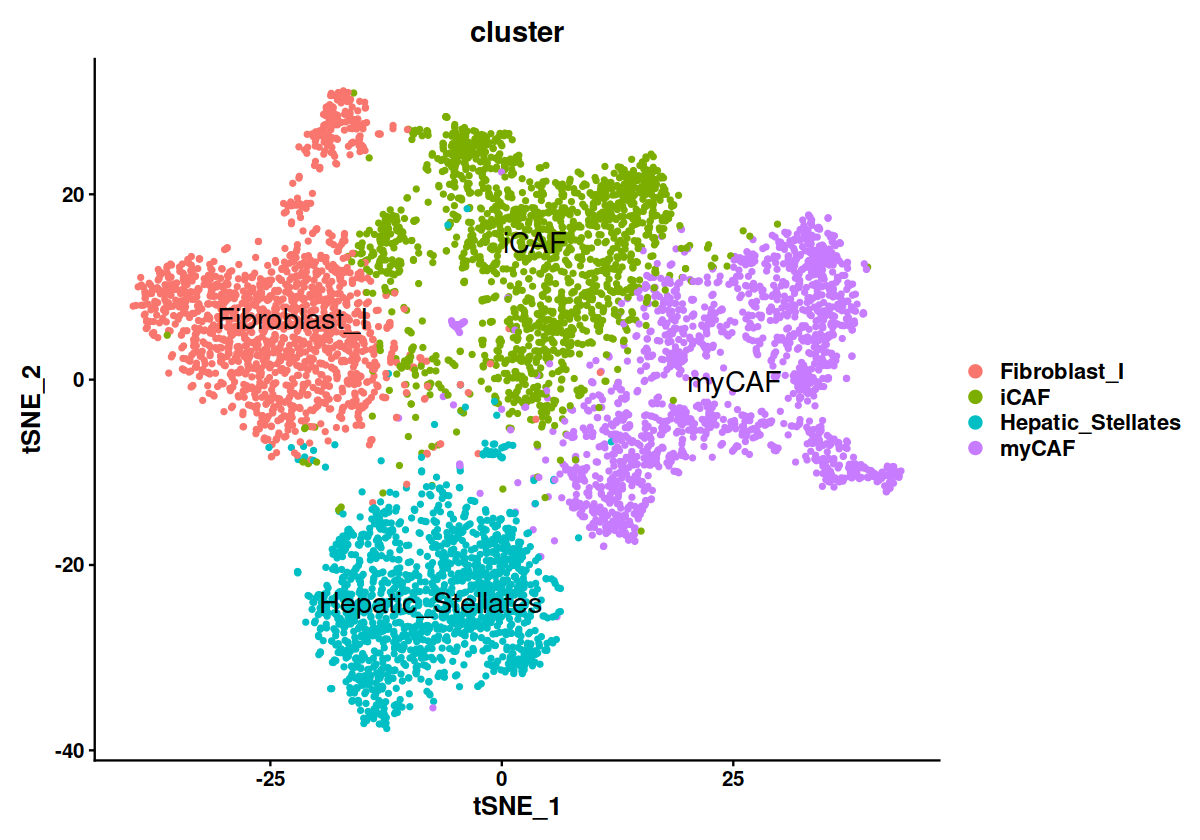

In [69]:
Idents(object) <- "seurat_clusters"
options(repr.plot.height=7,repr.plot.width= 10)
DimPlot(object, reduction = "tsne", label = TRUE, label.size = 6, pt.size = 1)

## C2, C3: Hepatic_Stellates
## 8, 4, 5, 12, 10 : myCAF
## 1,11,6,7: iCAF
## Fibroblast_I:  0, 9

Idents(object) <- "seurat_clusters"
current.cluster.ids <- c(c(2,3),
                        c(8, 4, 5, 12, 10),
                        c(1, 11, 6, 7),
                        c(0, 9))


new.cluster.ids <- c(c("Hepatic_Stellates","Hepatic_Stellates"),
                    c("myCAF","myCAF","myCAF","myCAF","myCAF"),
                    c("iCAF","iCAF","iCAF","iCAF"),
                    c("Fibroblast_I", "Fibroblast_I"))
                    
# new.cluster.ids
object@active.ident <- plyr::mapvalues(x = object@active.ident, from = current.cluster.ids, to = new.cluster.ids)

cell_type_df <- tibble::enframe( Idents(object), name="cell.name", value="cluster" ) %>% tibble::column_to_rownames("cell.name") 
object <- AddMetaData( object, cell_type_df )


options(repr.plot.height= 7,repr.plot.width= 10)
DimPlot(object, reduction = "tsne", label = TRUE, label.size = 6, pt.size = 1, group.by = "cluster")+ 
theme(axis.title=element_text(size=15,face="bold")) + theme(text = element_text(size = 15, face = "bold"))

options(repr.plot.height= 7,repr.plot.width= 7)

# Fibroblast: tSNE

Methods: 

1. Load object
2. change meta data( ACC_Met = MME, Adj_Tissue = AME, Healthy = HD)
3. subset object by sample types 
4. subsample each sub-object ( take cell numbers from lowset number of subsamples)
5. plot tsne plot 

### subset object by sample_types

In [5]:
mme <- subset(object, subset = sample_type == "MME")

ccme <- subset(object, subset = sample_type == "CCME")

hme <- subset(object, subset = sample_type == "HME")

table(object$sample_type)


CCME  HME  MME 
1057 3474 1878 

### sub-sample equal number of cells from each sample_types

In [6]:
# Object ccme is the  Seurat object with lowest number of cells (1057)

# Sample from hd and mme as many cells as there are cells in ame
# For reproducibility, set a random seed
cell.number <- min(table(object$sample_type)) # 1057
set.seed(112)
subsampled_mme <- mme[, sample(colnames(mme), size =cell.number, replace=F)]
subsampled_ccme <- ccme[, sample(colnames(ccme), size =cell.number, replace=F)]
subsampled_hme <- hme[, sample(colnames(hme), size =cell.number, replace=F)]

##  Merge your Seurat objects
obj.merged <- merge(subsampled_mme, c(subsampled_ccme, subsampled_hme))
obj.merged

obj <- object[, colnames(obj.merged)]


An object of class Seurat 
40145 features across 3171 samples within 3 assays 
Active assay: predActivity (1327 features, 0 variable features)
 2 other assays present: RNA, integrated

An object of class Seurat 
40145 features across 3171 samples within 3 assays 
Active assay: predActivity (1327 features, 0 variable features)
 2 other assays present: RNA, integrated
 3 dimensional reductions calculated: mnn, umap, tsne

In [ ]:
rm(obj.merged, hme, ccme, mme)

### plot: data: tsne/umap

png 
  2

png 
  2

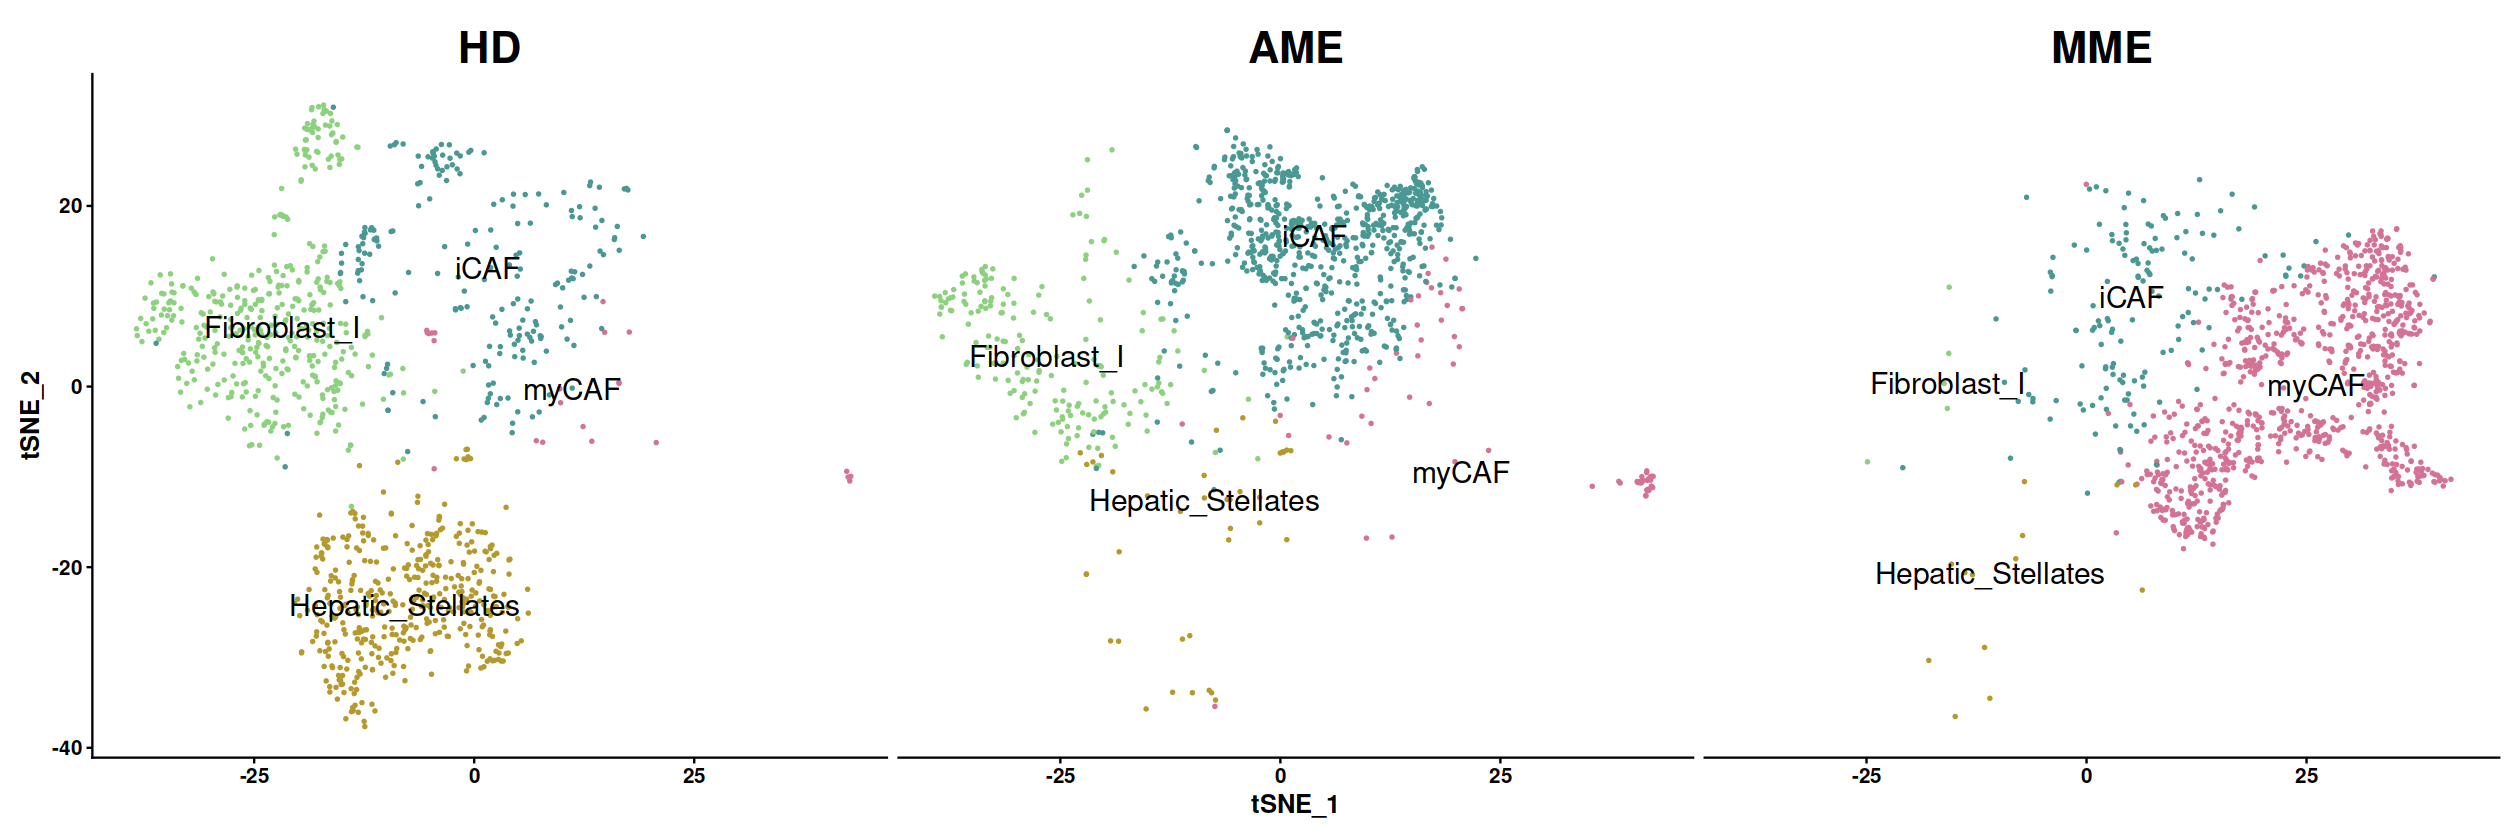

In [29]:
options(repr.plot.height = 7, repr.plot.width = 21)
obj$sample_type <- factor(obj$sample_type, levels = c("HME", "CCME", "MME")) ## order sample_type (HD>AME>MME)

p1 <- DimPlot(obj, reduction = "tsne",label = T, split.by = "sample_type", label.size = 6.2, pt.size = 0.5, cols = new.cols.crop)+ NoLegend()+
theme(text =  element_text(size = 30, face = "bold"),
    axis.title=element_text(size=15),
     plot.title = element_text(size=30, face='bold', hjust = 0.5),
    ) 

p1

options(repr.plot.height = 7, repr.plot.width = 7)

In [ ]:
rm(obj)

# Fibroblast: Barchart for proportion

Methods: 

1. load object
2. change meta data( ACC_Met = MME, Adj_Tissue = AME, Healthy = HD)
3. plot barchart

In [9]:
object$sample_type <- factor(object$sample_type, levels = c("MME", "CCME", "HME")) ## order sample_type (HD>AME>MME)

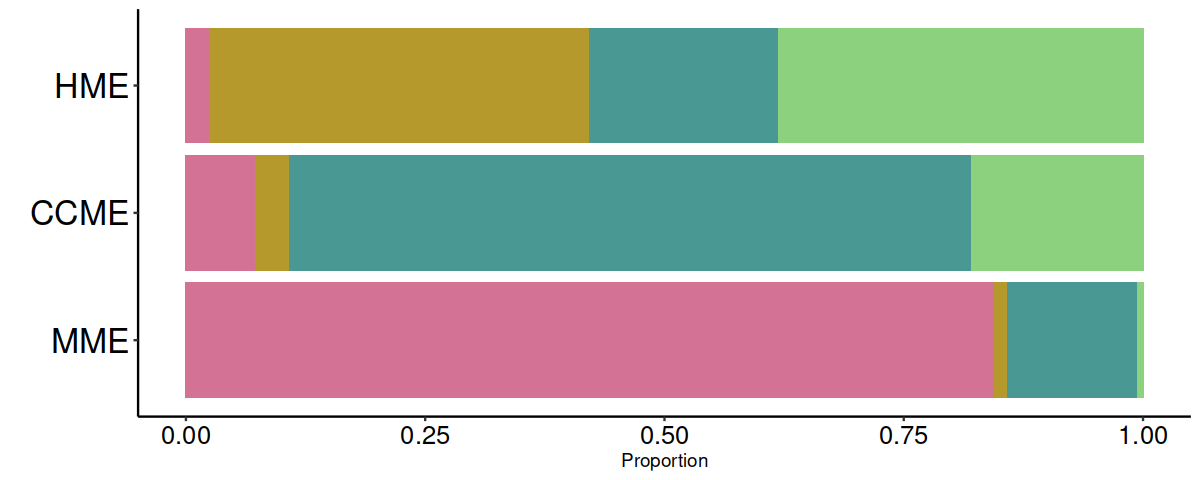

In [13]:
options(repr.plot.height= 4,repr.plot.width= 10)

p2 <- ggplot(object@meta.data, aes(x= sample_type, fill= cluster)) + geom_bar(position = "fill")+ coord_flip()+
scale_fill_manual(values=new.cols.crop)+
theme_classic() + 
theme(axis.text.x = element_text(size = 15, color = "black"),
    axis.text.y = element_text(size=20, color="black")) +  
labs(x = "", y = "Proportion") + NoLegend()

p2

options(repr.plot.height= 7,repr.plot.width= 7)

# Fibroblast: FeaturePlot/Dotplot

Methods:

1. load DEG for clusters of combined FastMNN Fibroblast object
2. filter markers with parameter filter(avg_log2FC >= 1.5, p_val_adj < 0.01) %>% top_n(5, -p_val_adj)
3. select top 5 genes for clusters based on p_val_adj
4. plot dotplot/FeaturePlot

In [ ]:
markers <- read.csv("../processed_data/Obj6_ACC_New_nLung_nLiver_Fibroblast_FastMNN_cluster_markers.csv")


top_markers <- markers %>% group_by(cluster) %>% filter(avg_log2FC >= 1.5, p_val_adj < 0.01) %>% top_n(5, -p_val_adj)

png 
  2

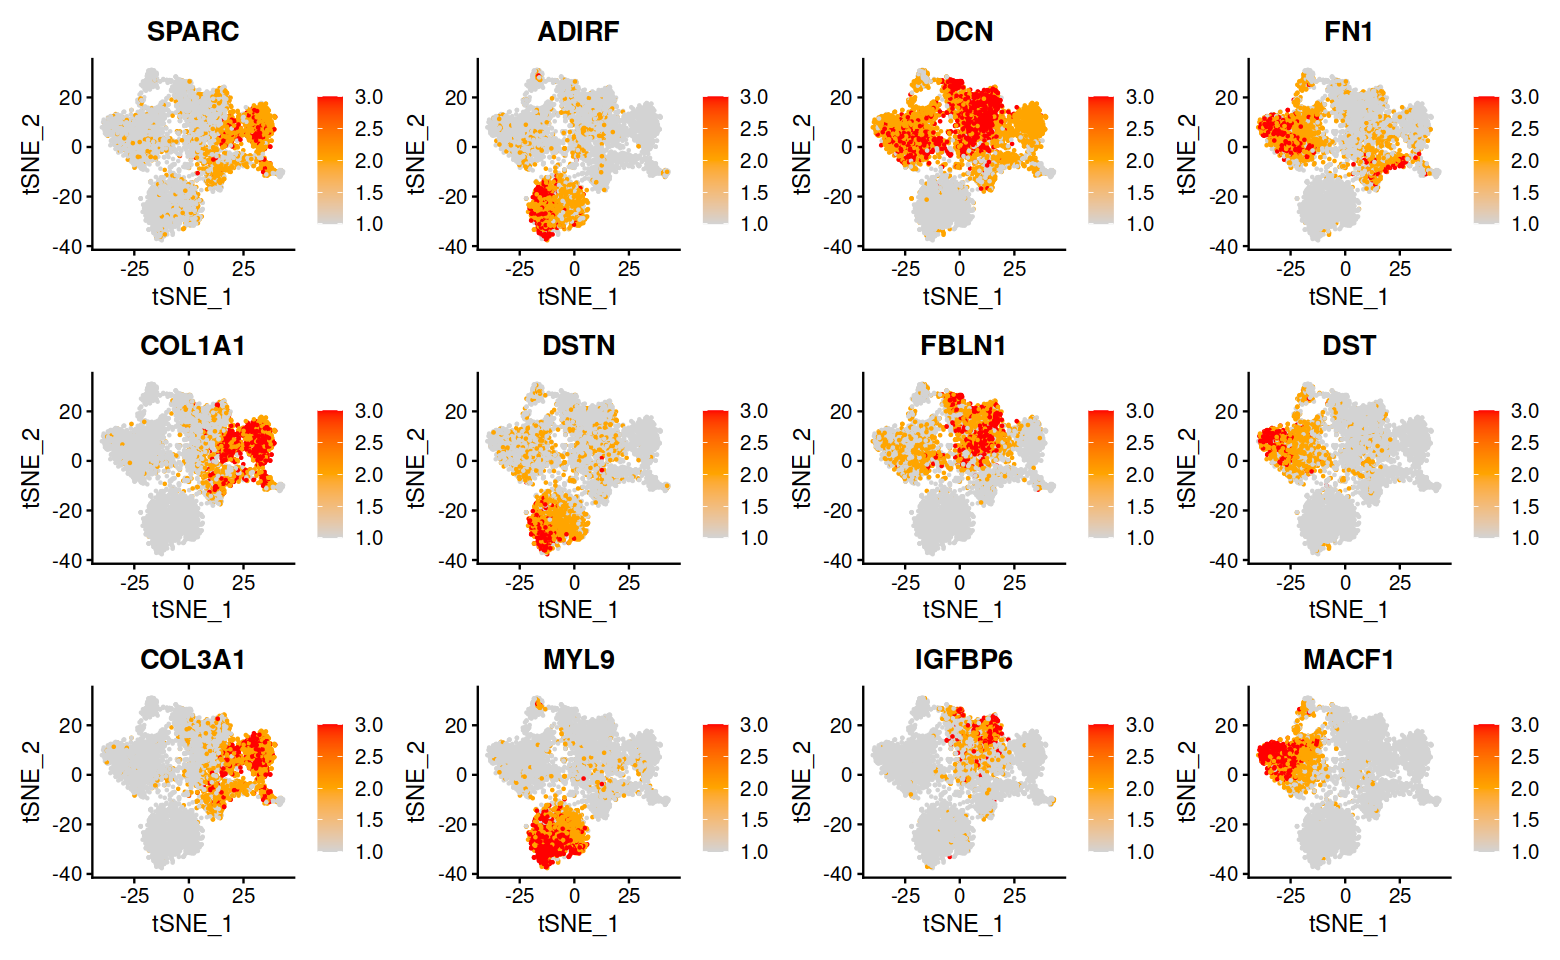

In [12]:
DefaultAssay(object) <- "RNA"
options(repr.plot.height= 8,repr.plot.width= 13)
p1 <- FeaturePlot(object, features = c( "SPARC","ADIRF","DCN","FN1",
                                 "COL1A1","DSTN","FBLN1", "DST",
                                 "COL3A1","MYL9", "IGFBP6", "MACF1"), min.cutoff = 1,reduction = "tsne", ncol = 4, label=F,
                   cols = c("lightgrey","orange", "red"))

p1
options(repr.plot.height = 7,repr.plot.width = 7)

# Fibroblast: Cell Clusters Enrichement

In [2]:
library(lme4, lib.loc = '../R/4.0/library')

In [3]:
obj <- readRDS( "../processed_data/Obj6_ACC_New_nLung_nLiver_Fibroblast_FastMNN.rds") 

count_df <- 
obj@meta.data %>% 
group_by(cluster, sample_type, site, patient_code) %>%
dplyr::count() %>%
dplyr::filter(site %in% c("Lung","Liver")) %>%
mutate(site=factor(site,levels=c("Lung","Liver")),
      sample_type=factor(sample_type,levels=c("Healthy","Adj_Tissue","ACC_Met")))

clusters <- unique(count_df$cluster)
coef_df <- data.frame()
for (cluster_ in clusters) {
    cluster_counts_df <- dplyr::filter(count_df,cluster == cluster_)
    
    unique_sites <- unique(cluster_counts_df$site)
    if (length(unique_sites) == 1)
        next
    
    out <- lme4::glmer(n ~ (1|patient_code) + site*sample_type, 
                      data=cluster_counts_df,family="poisson")  
        
    temp_df <- as.data.frame( coef(summary(out)) ) %>%
    tibble::rownames_to_column("coef") %>%
    dplyr::select(-c(`Std. Error`,`Estimate`)) %>%
    dplyr::filter(coef != "(Intercept)") %>%
    mutate(coef=gsub("site|sample_type","",coef)) %>%
    mutate(cell_type=cluster_)
    
    coef_df <- rbind(coef_df,temp_df)
}

p_value_df <- dplyr::select(coef_df,-`z value`)  %>%
mutate(coef=case_when(coef == "Liver" ~ "Liver vs Lung",
                     coef == "Adj_Tissue" ~ "CCME vs HME",
                     coef == "ACC_Met" ~ "MME vs HME",
                     TRUE ~ coef))
z_value_df <- dplyr::select(coef_df,-`Pr(>|z|)`) %>%
mutate(coef=case_when(coef == "Liver" ~ "Liver vs Lung",
                     coef == "Adj_Tissue" ~ "CCME vs HME",
                     coef == "ACC_Met" ~ "MME vs HME",
                     TRUE ~ coef))

z_value_mat <- tidyr::pivot_wider(z_value_df,names_from="coef",values_from="z value",
                  values_fill=0) %>% tibble::column_to_rownames("cell_type") %>%
as.matrix

p_value_mat <- tidyr::pivot_wider(p_value_df,names_from="coef",values_from="Pr(>|z|)",
                  values_fill=0) %>% tibble::column_to_rownames("cell_type") %>%
as.matrix

fixed-effect model matrix is rank deficient so dropping 2 columns / coefficients

fixed-effect model matrix is rank deficient so dropping 1 column / coefficient

fixed-effect model matrix is rank deficient so dropping 1 column / coefficient

fixed-effect model matrix is rank deficient so dropping 1 column / coefficient



In [6]:
row.order <- c("Hepatic_Stellates","Fibroblast_I","iCAF",
                             "myCAF")

ordered_mat <- z_value_mat[row.order,]

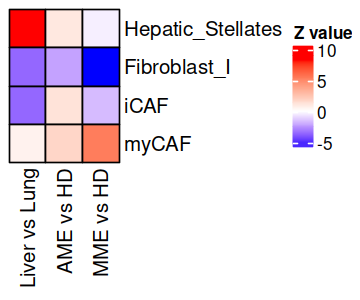

In [14]:
colors <- circlize::colorRamp2(c(min(ordered_mat),0,max(ordered_mat)),c("blue","white","red"))

options(repr.plot.width=3,repr.plot.height=2.5)
Heatmap( ordered_mat[, 1:3], na_col = "white", col=colors, 
        name="Z value", cluster_columns=F, cluster_rows=F, 
       rect_gp=gpar(lwd=1,col="black"))
options(repr.plot.width=7,repr.plot.height=7)

# Fibroblast: GSEA of iCAF

Methods: 

1. Load object
2. load markers (cluster vs all other cells)
3. filter markers by cluster  filter(cluster == "iCAF", p_val_adj < 0.05, avg_log2FC > 0.25)
4. remove ribosomal genes
5. subsample each sub-object ( take cell numbers from lowset subsamples)
6. load source code 
7. convert gene symbol to ENTREZID by running function gene.df_function and geneID_converter_1
8. generate backgound genes (genes that expressed in at least 10% of cells) by running back_gene_func
9. run enrichGO 
10. filter selective significant pathways for dotplot and cnetplot

In [14]:
## load markers
markers <- read.csv("../processed_data/Obj6_ACC_New_nLung_nLiver_Fibroblast_FastMNN_cluster_markers.csv")
markers_filtered <- markers %>% filter(cluster == "iCAF", p_val_adj < 0.05, avg_log2FC > 0.25) %>% arrange(desc(avg_log2FC))
markers_filtered <- markers_filtered[!grepl("^RP",markers_filtered$gene),] # remove ribosomal genes

In [16]:
# load source code
source('../code/ClusterProfilterFunction.R')

gene.df <- gene.df_function(markers_filtered)
GeneList <- geneID_converter_I(markers_filtered)
back_gene <- back_gene_func(object)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(gene, fromType = "ALIAS", toType = c("ENSEMBL", "ENTREZID", :
“1.02% of input gene IDs are fail to map...”
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(gene, fromType = "ALIAS", toType = c("ENSEMBL", "ENTREZID", :
“55.62% of input gene IDs are fail to map...”
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(gene, fromType = "ALIAS", toType = c("ENSEMBL", "ENTREZID", :
“1.09% of input gene IDs are fail to map...”


In [17]:
## GO

ego3 <- enrichGO(gene         = gene.df$SYMBOL, universe = back_gene[, 1],
                OrgDb         = org.Hs.eg.db,
                keyType       = 'SYMBOL',
                ont           = "ALL", ## BP,CC,MF
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05)

In [18]:
## filter selective significant pathways
x <- ego3[ego3$Description %in% c('collagen-containing extracellular matrix','extracellular matrix organization','epithelial cell proliferation', 
                                  "regulation of vasculature development",'negative regulation of immune system process',
                                  'regulation of endopeptidase activity','negative regulation of T cell activation',
                                  'regulation of leukocyte migration','myeloid cell differentiation',
                                
                                  'T cell activation','response to oxidative stress','regulation of I-kappaB kinase/NF-kappaB signaling',
                                  'regulation of inflammatory response','neutrophil activation involved in immune response', 
                                  'response to hypoxia', 'regulation of angiogenesis'), asis = TRUE]

x@result[x@result == 'regulation of I-kappaB kinase/NF-kappaB signaling'] <- 'regulation of I-kappaB/NF-kappaB signaling'

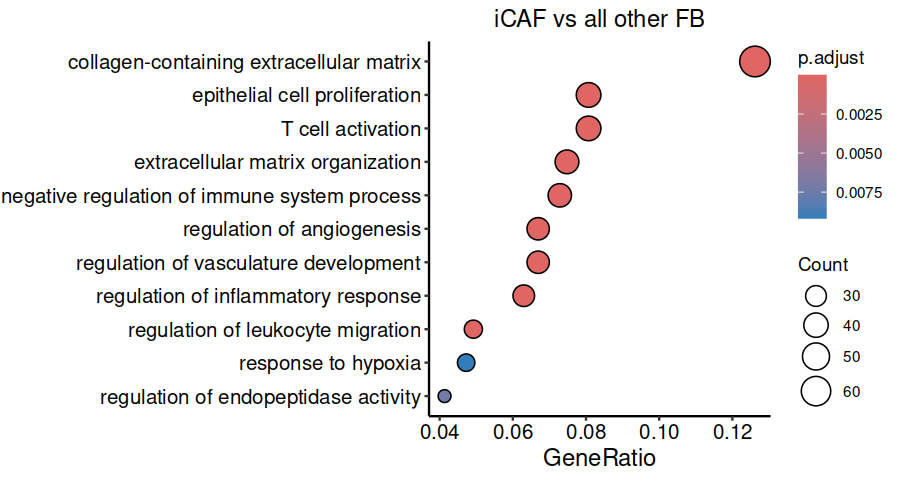

In [19]:
p1 <- dotplot(x, showCategory= 50, label_format = 60) + ggtitle("iCAF vs all other FB") + 
theme_classic() + 
scale_color_gradient(low = new.cols.crop[2], high = new.cols.crop[2]) +
    theme(axis.text = element_text(size = 12, color = "black"),
            axis.title.x = element_text(hjust = 0.5, size=14, color = "black"),
            plot.title = element_text(hjust = 0.5, size=14))  

options(repr.plot.height = 4, repr.plot.width = 7.5)
p1
options(repr.plot.height = 7, repr.plot.width = 7)

Warning message in cnetplot.enrichResult(x, ...):
“Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version.”
Warning message in cnetplot.enrichResult(x, ...):
“Use 'color.params = list(edge = your_value)' instead of 'colorEdge'.
 The colorEdge parameter will be removed in the next version.”
Warning message in cnetplot.enrichResult(x, ...):
“Use 'cex.params = list(category_label = your_value)' instead of 'cex_label_category'.
 The cex_label_category parameter will be removed in the next version.”
Warning message in cnetplot.enrichResult(x, ...):
“Use 'cex.params = list(gene_label = your_value)' instead of 'cex_label_gene'.
 The cex_label_gene parameter will be removed in the next version.”
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


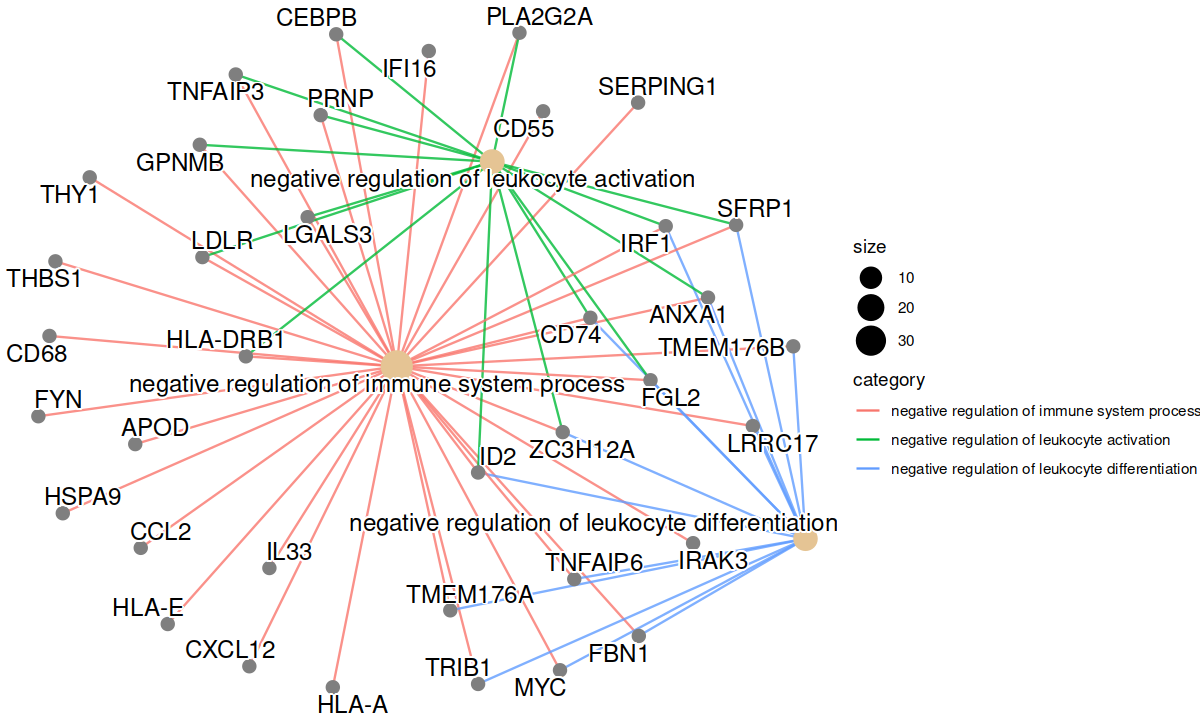

In [20]:
## filter selective significant pathways
x <- ego3[ego3$Description %in% c("negative regulation of immune system process",'negative regulation of leukocyte differentiation',
                                 'negative regulation of leukocyte activation',
                                 'negative regulation of T cell activation'), asis = TRUE]

p2 <- cnetplot(x, categorySize="p.adjust", foldChange=GeneList,showCategory = 20,
              colorEdge = T, cex_label_category = 1, max.overlaps = 100,
         cex_label_gene = 1)

options(repr.plot.height = 6, repr.plot.width = 10)
p2
options(repr.plot.height = 7, repr.plot.width = 7)

# Fibroblast: GSEA of myCAF

In [71]:
## load markers
markers <- read.csv("../processed_data/Obj6_ACC_New_nLung_nLiver_Fibroblast_FastMNN_cluster_markers.csv")
markers_filtered <- markers %>% filter(cluster == "myCAF", p_val_adj < 0.05, avg_log2FC > 0.25) %>% arrange(desc(avg_log2FC))
markers_filtered <- markers_filtered[!grepl("^RP",markers_filtered$gene),] # remover ribosomal genes

In [72]:
# load source code
source('/vf/users/Vishaka_Omar/Project/code/ClusterProfilterFunction.R')

gene.df <- gene.df_function(markers_filtered)
GeneList <- geneID_converter(markers_filtered)
back_gene <- back_gene_func(object)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(gene, fromType = "ALIAS", toType = c("ENSEMBL", "ENTREZID", :
“1.64% of input gene IDs are fail to map...”
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(gene, fromType = "ALIAS", toType = c("ENSEMBL", "ENTREZID", :
“1.64% of input gene IDs are fail to map...”
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(gene, fromType = "ALIAS", toType = c("ENSEMBL", "ENTREZID", :
“1.1% of input gene IDs are fail to map...”


In [73]:
gene <- names(GeneList)[GeneList >= 0.5]

# GO
ego3 <- enrichGO(gene         = gene.df$SYMBOL, universe = back_gene[, 1],
                OrgDb         = org.Hs.eg.db,
                keyType       = 'SYMBOL',
                ont           = "ALL", ## BP,CC,MF
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05)

In [74]:
x <- ego3[ego3$Description %in% c('extracellular matrix', 'blood vessel development', 'blood vessel morphogenesis',
                                 'extracellular matrix organization', 'response to wounding', 'wound healing',
                                  'collagen metabolic process', 'growth factor binding', 'complex of collagen trimers'), asis = TRUE]

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


png 
  2

png 
  2

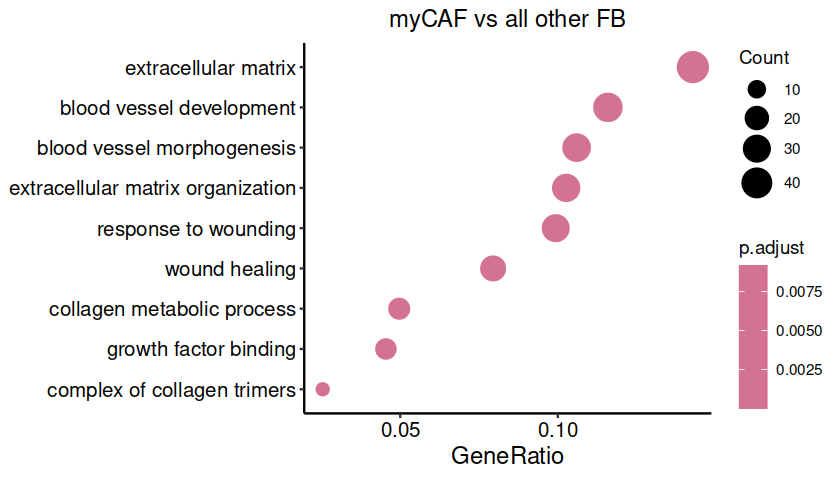

In [79]:
p1 <- dotplot(x, showCategory= 50,label_format = 60) + ggtitle("myCAF vs all other FB") + 
theme_classic() + 
scale_color_gradient(low = new.cols.crop[4], high = new.cols.crop[4]) +
    theme(axis.text = element_text(size = 12, color = "black"),
            axis.title.x = element_text(hjust = 0.5, size=14, color = "black"), 
            plot.title = element_text(hjust = 0.5, size=14))  

options(repr.plot.height = 4, repr.plot.width = 7)
p1
options(repr.plot.height = 4, repr.plot.width = 7)

# Fibroblast: iCAF and myCAF signatures for survival analysis

Methods: 
1. Combined object derived DEG for Fibroblast cell clusters
2. Removed Ribosomal genes : markers[!grepl("^RP",markers$gene),]
3. Derived top50 significant genes as a gene signatures for each
4. Cluster : filter(p_val_adj < 0.01, avg_log2FC > 0.5) %>% top_n(n = 50, wt = avg_log2FC)
5. top50
6. Run the SurvivalGenie with using to50 gene signatures with 
7. Select Groups as  ”Cutp”  


In [21]:
markers <- read.csv("../processed_data/Obj6_ACC_New_nLung_nLiver_Fibroblast_FastMNN_cluster_markers.csv")
markers <- markers[!grepl("^RP",markers$gene),]

top50 <- markers %>% group_by(cluster) %>% filter(p_val_adj < 0.01, avg_log2FC > 0.5) %>% top_n(n = 50, wt = avg_log2FC)
markers <- top50

In [22]:
iCAF <- markers %>% filter(cluster == 'iCAF')
'iCAF markers = '
iCAF %>% pull(gene)

[1] "iCAF markers = "

[1] "IGFBP6"   "GSN"      "FBLN1"    "DCN"      "C3"       "CCDC80"  
 [7] "CFD"      "SCARA5"   "SERPINF1" "GPNMB"    "CLU"      "FBLN2"   
[13] "UAP1"     "MT1A"     "LEPR"     "CST3"     "NAMPT"    "PI16"    
[19] "MT1M"     "OGN"      "C1R"      "SFRP1"    "PODN"     "MT2A"    
[25] "ACKR3"    "SOCS3"    "MFAP5"    "PCOLCE2"  "SOD2"     "MT1X"    
[31] "CEBPD"    "MEDAG"    "CCL2"     "ATP1B3"   "CCN5"     "RDH10"   
[37] "AKAP12"   "HAS1"     "IL6"      "ICAM1"    "THBS1"    "SFRP4"   
[43] "PLA2G2A"  "MEG3"     "CH25H"    "PTX3"     "TNXB"     "CXCL14"  
[49] "FBN1"     "TNFAIP6"

In [94]:
myCAF <- markers %>% filter(cluster == 'myCAF')
'myCAF markers = '
myCAF %>% pull(gene)

[1] "myCAF markers = "

[1] "BGN"      "TIMP1"    "COL3A1"   "COL1A1"   "POSTN"    "SPARC"   
 [7] "COL4A1"   "COL4A2"   "COL1A2"   "GGT5"     "CTHRC1"   "APOE"    
[13] "COL5A2"   "IGFBP2"   "INHBA"    "TGFBI"    "TMSB10"   "LGALS1"  
[19] "SERPINH1" "THY1"     "COL5A1"   "GAPDH"    "SERPINE1" "NNMT"    
[25] "ASPN"     "CLEC11A"  "PPIB"     "FAP"      "AREG"     "COL6A3"  
[31] "SERF2"    "THBS2"    "RCN3"     "TPT1"     "PRSS23"   "RAB13"   
[37] "AP2S1"    "PCOLCE"   "PLOD2"    "VCAN"     "SNHG29"   "IGF1"    
[43] "PPP1R14B" "SFRP2"    "SERPINE2" "IGFBP4"   "KDELR3"   "SPON2"   
[49] "OSTC"     "SLPI"

# Fibroblast: ECM Gene Expression

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


png 
  2

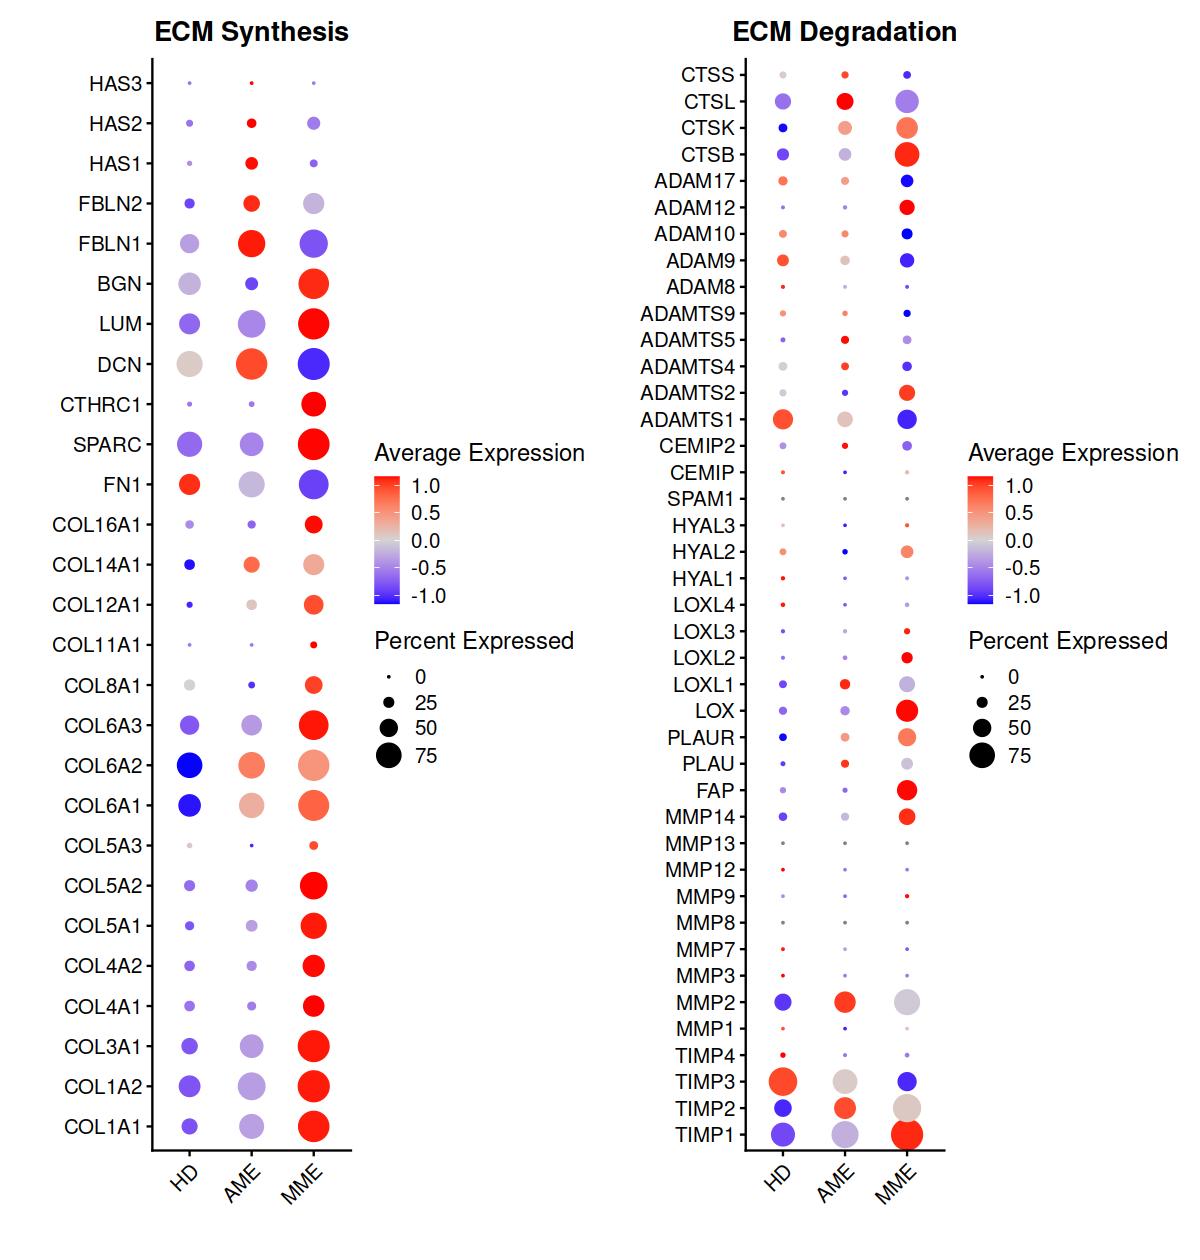

In [11]:
## ECM genes
ecm_synthesis <- c("COL1A1", "COL1A2", "COL3A1", "COL4A1", "COL4A2", "COL5A1", "COL5A2", "COL5A3", "COL6A1", "COL6A2",
               "COL6A3", "COL8A1", "COL11A1", "COL12A1", "COL14A1", "COL16A1","FN1","SPARC",'CTHRC1', "DCN","LUM", "BGN",
              "FBLN1","FBLN2","HAS1", "HAS2", "HAS3")
ecm_degradation <- c("TIMP1", "TIMP2", 'TIMP3', 'TIMP4', 
                     'MMP1', "MMP2", 'MMP3', 'MMP7', 'MMP8', "MMP9", "MMP12", 'MMP13', "MMP14", 
                     'FAP', 'PLAU', 'PLAUR', 
                     'LOX', 'LOXL1', 'LOXL2', 'LOXL3', 'LOXL4', 
                     'HYAL1', 'HYAL2', 'HYAL3', 'SPAM1', 'CEMIP', 'CEMIP2',
                     'ADAMTS1', 'ADAMTS2', 'ADAMTS4', 'ADAMTS5', 'ADAMTS9', 
                     'ADAM8', 'ADAM9', 'ADAM10', 'ADAM12', 'ADAM17', 
                    'CTSB', 'CTSK', 'CTSL', 'CTSS')
object$sample_type <- factor(object$sample_type, levels = c("HME", "CCME", "MME")) ## order sample_type 

p1 <- DotPlot(object, features = ecm_synthesis,   group.by = "sample_type", #cols = c("gray", "red"), 
        col.min = -2.0, col.max = 2,
        assay = "RNA",  dot.scale = 8)+ coord_flip()+ RotatedAxis()+
scale_colour_gradient2(low="blue", mid="lightgrey", high="red")+
ggtitle("ECM Synthesis")+ theme(plot.title = element_text(hjust = 0.5))+
xlab("")+ ylab("")+
theme(axis.title.y =element_text(hjust = 0.5, size = 15, face = "bold"), 
      axis.title.x = element_text(hjust = 0.5, size = 15, face = "bold"))

p2 <- DotPlot(object, features = ecm_degradation,   group.by = "sample_type", #cols = c("gray", "red"), 
        col.min = -2.0, col.max = 2,
        assay = "RNA",  dot.scale = 8)+ coord_flip()+ RotatedAxis()+
scale_colour_gradient2(low="blue", mid="lightgrey", high="red")+
ggtitle("ECM Degradation")+ theme(plot.title = element_text(hjust = 0.5))+
xlab("")+ ylab("")+
theme(axis.title.y =element_text(hjust = 0.5, size = 15, face = "bold"), 
      axis.title.x = element_text(hjust = 0.5, size = 15, face = "bold"))

options(repr.plot.height = 10.5, repr.plot.width = 10)
p1 | p2
options(repr.plot.height = 7, repr.plot.width = 7)

# Fibroblast: Trajectory analysis 

Methodology:
1. load library
2. load object, change metadata sample_types if needs
3. retrieve expression metrix and metadata columns 
4. create monocle object, do batch correction by patient_code, do dimensional reduction, clustering and learn trajectory graph
5. order cells along the trajectory, and set root nodes
6. plot Trajectory graph

In [ ]:
library(VGAM)
library(htmlwidgets)
library(monocle3)

## Create monocle object

In [4]:
# retrieve expression matrix and metadata
FB_lung <- subset(object, subset = site == "Lung")

DefaultAssay(FB_lung) <- "RNA" # assay = RNA
gene_annotation <- data.frame(gene_short_name = row.names(FB_lung), row.names = row.names(FB_lung)) ## retrive genes
colnames(gene_annotation) <- "gene_short_name"

# part two, cell information: 

cell_metadata <- FB_lung@meta.data %>% select("cluster", "sample_type", "patient_code", "site") %>% as.data.frame()
colnames(cell_metadata)[1] <- "cell_type"

# part three, counts sparse matrix
expression_matrix <- FB_lung@assays[["RNA"]]@counts

In [5]:
## create monocle object, do batch correction by patient_code, do dimensional reduction, clustering and learn trajectory graph
cds <- new_cell_data_set(expression_matrix,
                                     cell_metadata = cell_metadata,
                                     gene_metadata = gene_annotation)

## pre-processing
cds <- preprocess_cds(cds, num_dim = 50)

## batch correction by patient_code
cds <- align_cds(cds, alignment_group = "patient_code")

## Reduce Dimension
cds <- reduce_dimension(cds)

cds <- cluster_cells(cds)
cds <- learn_graph(cds)

Aligning cells from different batches using Batchelor.
Please remember to cite:
	 Haghverdi L, Lun ATL, Morgan MD, Marioni JC (2018). 'Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.' Nat. Biotechnol., 36(5), 421-427. doi: 10.1038/nbt.4091

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, sp

  |======================================================================| 100%
  |======================================================================| 100%


## Make trajectory plots

Cells aren't colored in a way that allows them to be grouped.



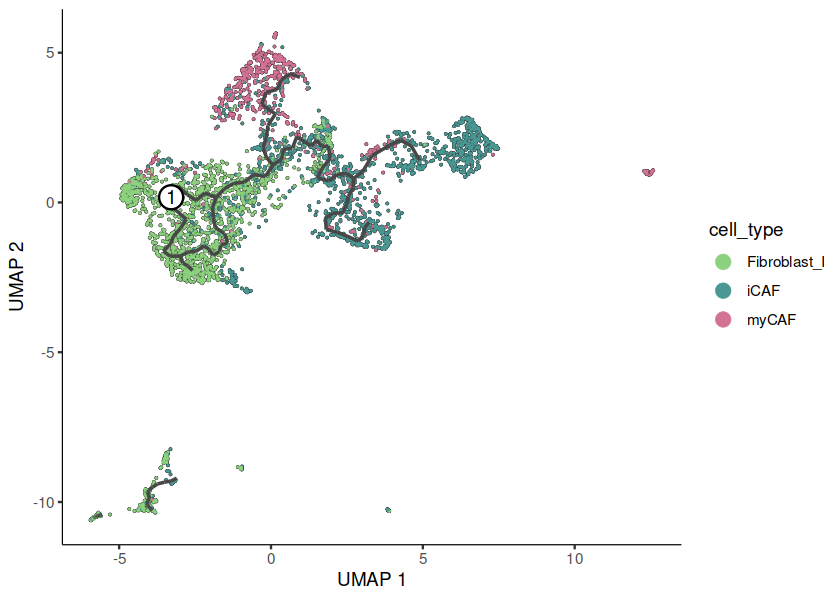

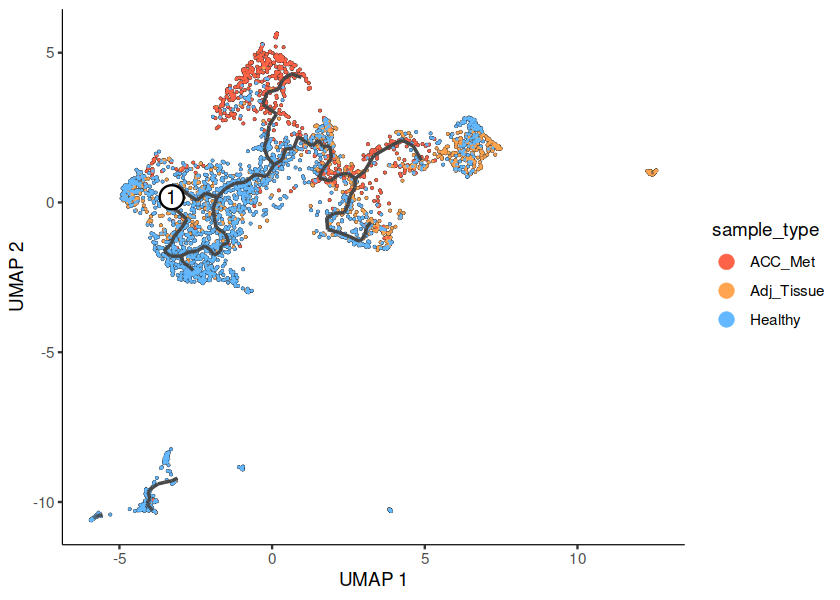

png 
  2

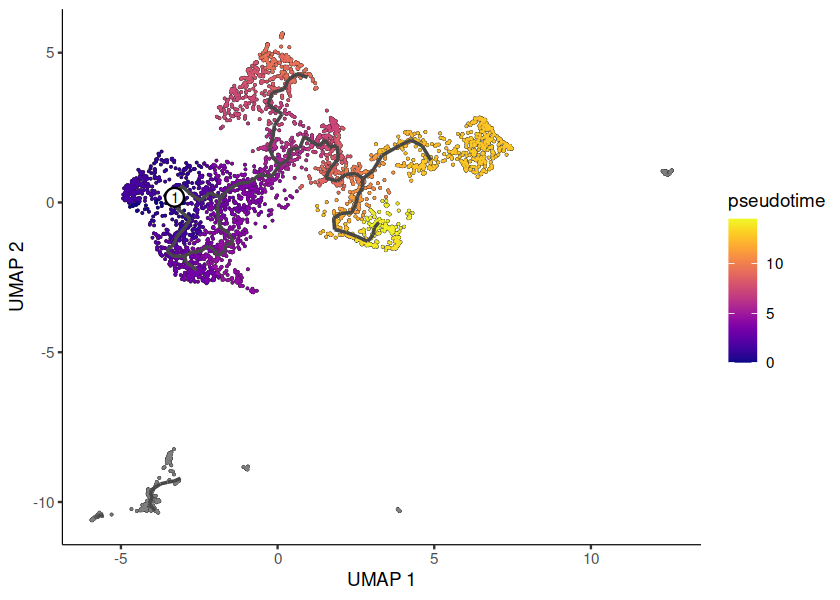

In [10]:
#get earliest principal node
plot_pseudotime <- function(cds, cell_to_start){
    get_earliest_principal_node <- function(cds, time_bin=cell_to_start){
  cell_ids <- which(colData(cds)[, "cell_type"] == time_bin)
  
  closest_vertex <-
  cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <-
  igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names
  (which.max(table(closest_vertex[cell_ids,]))))]
  
  root_pr_nodes
}
    
cds <- order_cells(cds, root_pr_nodes=get_earliest_principal_node(cds))

p1 <- plot_cells(cds,
           color_cells_by = "cell_type",
            label_cell_groups = F,
           label_leaves=F,
           label_branch_points=F, 
          group_label_size = 5,
          graph_label_size = 4, 
           cell_size = 0.35) + 
    scale_color_manual(values = c(new.cols[6], new.cols[9], new.cols[15]))
    
print(p1)
      
p2 <- plot_cells(cds,
           color_cells_by = "sample_type",
           #label_groups_by_cluster=F,
            label_cell_groups = F,
           label_leaves=F,
           label_branch_points=F, 
          group_label_size = 5,
          graph_label_size = 4, 
           cell_size = 0.35) + 
    scale_color_manual(values = c("tomato", "tan1", "steelblue1")) 
    
print(p2)
    
p3 <- plot_cells(cds,
           color_cells_by = "pseudotime",
           label_groups_by_cluster=T,
           label_leaves=F,
           label_branch_points=F, 
          graph_label_size = 3, 
           cell_size = 0.35)
print(p3)
}

options(repr.plot.height = 5, repr.plot.width = 7)
plot_pseudotime(cds, cell_to_start = "Fibroblast_I")
options(repr.plot.height = 7, repr.plot.width = 7)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


png 
  2

png 
  2

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


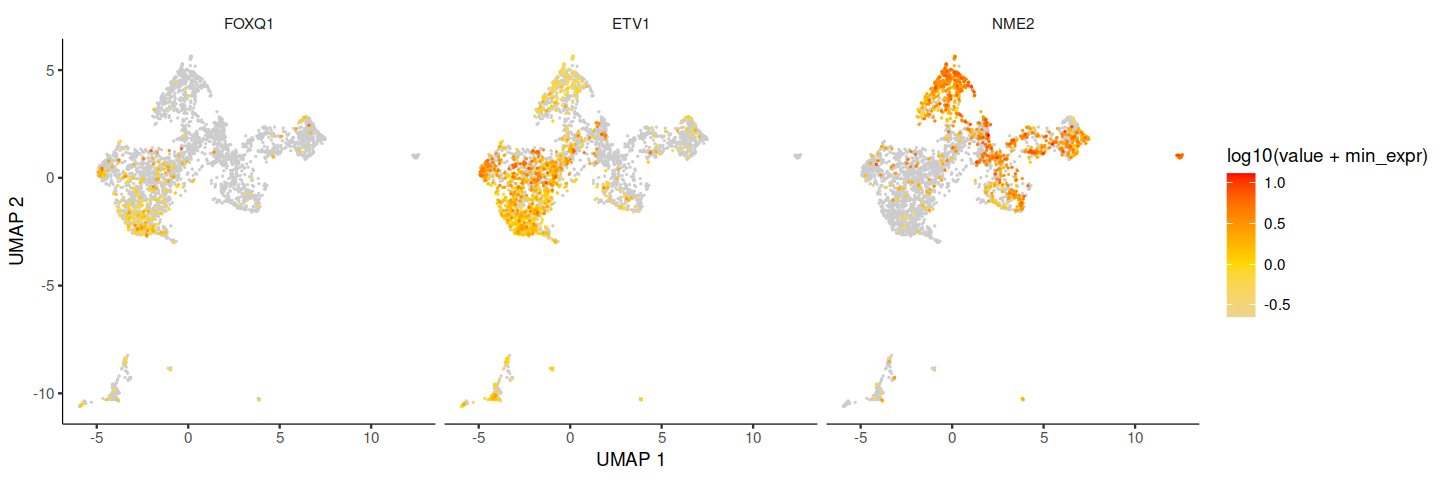

png 
  2

png 
  2

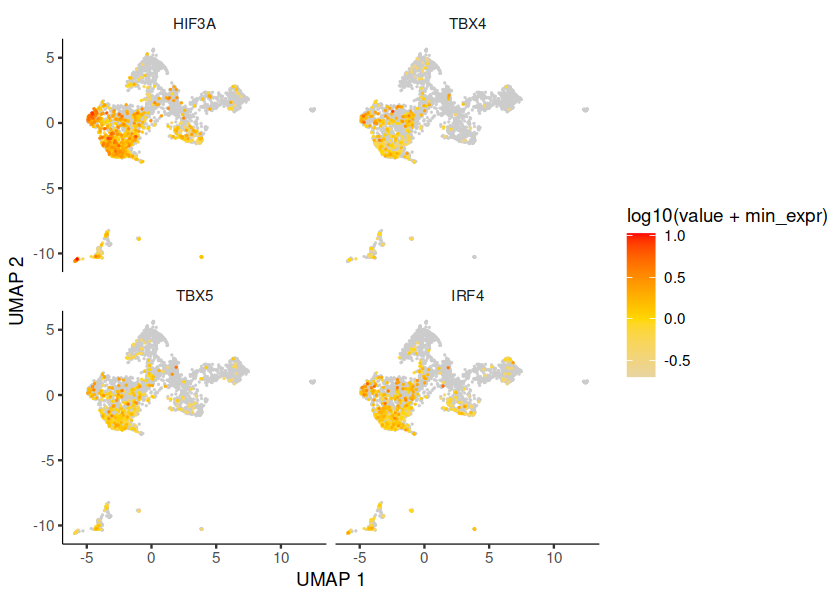

In [20]:
# plot graphs of differential TFs
final_tfs <- c('FOXQ1', 'ETV1', 'NME2')
supplemental_tfs <- c('HIF3A', 'TBX4', 'TBX5', 'IRF4')

p1 <- plot_cells(cds, genes = final_tfs, 
           scale_to_range = F,
           show_trajectory_graph = F,
           label_cell_groups = F,
           label_leaves = F,
           label_branch_points = F) + 
    scale_color_gradient2(low = "lightgrey", mid = "gold1", high = "red")

options(repr.plot.height = 4, repr.plot.width = 12)
p1

p2 <- plot_cells(cds, genes = supplemental_tfs, 
           scale_to_range = F,
           show_trajectory_graph = F,
           label_cell_groups = F,
           label_leaves = F,
           label_branch_points = F) + 
    scale_color_gradient2(low = "lightgrey", mid = "gold1", high = "red")

options(repr.plot.height = 5, repr.plot.width = 7)
p2
options(repr.plot.height = 7, repr.plot.width = 7)